In [12]:
import os
import glob
import torch
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

%matplotlib inline

In [59]:
class_names = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Change the paths according to your directory

In [15]:
# Define paths 
train_images_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/train/images"
train_labels_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/train/labels"
valid_images_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/valid/images"
valid_labels_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/valid/labels"
test_images_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/test/images"
test_labels_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/test/labels"

# Get image and label files from directory
train_image_files = sorted(glob.glob(os.path.join(train_images_path, "*.png")) + glob.glob(os.path.join(train_images_path, "*.jpg")))
train_label_files = sorted(glob.glob(os.path.join(train_labels_path, "*.txt")))
valid_image_files = sorted(glob.glob(os.path.join(valid_images_path, "*.png")) + glob.glob(os.path.join(valid_images_path, "*.jpg")))
valid_label_files = sorted(glob.glob(os.path.join(valid_labels_path, "*.txt")))
test_image_files = sorted(glob.glob(os.path.join(test_images_path, "*.png")) + glob.glob(os.path.join(test_images_path, "*.jpg")))
test_label_files = sorted(glob.glob(os.path.join(test_labels_path, "*.txt")))

# Read class_id (from label txt)
def load_labels(label_file):
  with open(label_file, 'r') as f:
    train_label = f.readlines()
    class_id = int(train_label[0].split()[0])   # Extract class_id (first element)
    return class_id

def preprocess_image(image_file):
    image = Image.open(image_file).convert("RGB")  # Open image
    image_array = np.array(image).flatten()
    return image_array

# maps labels to images and preprocess images by first creating [3, 96, 96] (RGB 96x96 image) arrays and then flattening them to 1D arrays of length: 3 * 96 * 96
train_image_data = []
train_class_labels = []
valid_image_data = []
valid_class_labels = []
test_image_data = []
test_class_labels = []

# Training Data mapping
for label_file, image_file in zip(train_label_files, train_image_files) :
    label = load_labels(label_file)
    image = preprocess_image(image_file)
    train_class_labels.append(label)
    train_image_data.append(image)
    
# Validation Data mapping
for label_file, image_file in zip(valid_label_files, valid_image_files):
    label = load_labels(label_file)
    image = preprocess_image(image_file)
    valid_class_labels.append(label)
    valid_image_data.append(image)

# Testing Data mapping
for label_file, image_file in zip(test_label_files, test_image_files):
    label = load_labels(label_file)
    image = preprocess_image(image_file)
    test_class_labels.append(label)
    test_image_data.append(image)

train_class_labels = np.array(train_class_labels)
train_image_data = np.array(train_image_data)
valid_class_labels = np.array(valid_class_labels)
valid_image_data = np.array(valid_image_data)
test_class_labels = np.array(test_class_labels)
test_image_data = np.array(test_image_data)


In [4]:
def nearest_neighbor_classifier(train_data, train_labels, test_data, k=1):
    distances = cdist(test_data, train_data, metric='euclidean') 
    nearest_neighbors = np.argsort(distances, axis=1)[:, :k] # sorts and creates a [# of test samples, # of trainig samples] array with each index of k-neighboring training sample as a value
    nearest_labels = train_labels[nearest_neighbors] # 2D array, with each row corresponding to the labels of the k nearest neighbors for a given test sample
    if k > 1:
        test_pred = [np.bincount(row).argmax() for row in nearest_labels] 
    else:
        test_pred = nearest_labels.flatten()
    return np.array(test_pred)

def nearest_class_centroid_classifier(train_data, train_labels, test_data):
    unique_classes = np.unique(train_labels)
    centroids = np.array([train_data[train_labels == cls].mean(axis=0) for cls in unique_classes])
    distances = cdist(test_data, centroids, metric='euclidean')
    test_pred = unique_classes[np.argmin(distances, axis=1)]
    return test_pred


In [96]:
nn_1_pred = nearest_neighbor_classifier(train_image_data, train_class_labels, valid_image_data, k=1) # Execution time: 483 secs

In [45]:
nn_3_pred = nearest_neighbor_classifier(train_image_data, train_class_labels, valid_image_data, k=3) # Execution time: 811 secs

In [47]:
ncc_pred = nearest_class_centroid_classifier(train_image_data, train_class_labels, valid_image_data) # Execution time: 10 secs

In [43]:
# Accuracy
print("1-NN Accuracy:", '%.3f'%((accuracy_score(valid_class_labels, nn_1_pred))*100),"%")
print("3-NN Accuracy:", '%.3f'%((accuracy_score(valid_class_labels, nn_3_pred))*100),"%")
print("NCC Accuracy:", '%.3f'%((accuracy_score(valid_class_labels, ncc_pred))*100),"%")


1-NN Accuracy: 25.213 %
3-NN Accuracy: 23.714 %
NCC Accuracy: 22.993 %


In [18]:
def nearest_neighbor_classifier_cuda(train_data, train_labels, test_data, k=1):
    # Move data to GPU if available and convert to float
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_data = torch.tensor(train_data, dtype=torch.float32, device=device)
    test_data = torch.tensor(test_data, dtype=torch.float32, device=device)
    train_labels = torch.tensor(train_labels, device=device)
    
    # Compute the squared Euclidean distance
    dists = torch.cdist(test_data, train_data, p=2)  # Calculate euklidean distance between all test data samples and all training samples
    nearest_neighbors = torch.argsort(dists, dim=1)[:, :k]
    nearest_labels = train_labels[nearest_neighbors]
    if k > 1:
        # Majority voting for k-NN
        test_pred = [torch.mode(row).values.item() for row in nearest_labels]
    else:
        test_pred = nearest_labels.flatten().cpu().numpy()
    
    return np.array(test_pred)

def nearest_class_centroid_classifier_cuda(train_data, train_labels, test_data):
    # Move data to GPU if available and convert to float
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_data = torch.tensor(train_data, dtype=torch.float32, device=device)
    test_data = torch.tensor(test_data, dtype=torch.float32, device=device)
    
    # Calculate centroids for each class
    unique_classes = np.unique(train_labels)
    centroids = []
    for cls in unique_classes:
        class_data = train_data[train_labels == cls]
        centroid = class_data.mean(dim=0)
        centroids.append(centroid)
    centroids = torch.stack(centroids).to(device)
    
    # Assign each test sample to the nearest centroid
    distances = torch.cdist(test_data, centroids, p=2)
    test_pred = unique_classes[torch.argmin(distances, dim=1).cpu().numpy()]
    return test_pred

In [35]:
nn_1_val = nearest_neighbor_classifier_cuda(train_image_data, train_class_labels, valid_image_data, k=1) # Execution time: 92 secs

[0 4 4 ... 2 3 7]


In [37]:
nn_3_val = nearest_neighbor_classifier_cuda(train_image_data, train_class_labels, valid_image_data, k=3) # Execution time: 84 secs

[0 4 4 ... 2 7 7]


In [9]:
ncc_val = nearest_class_centroid_classifier_cuda(train_image_data, train_class_labels, valid_image_data) # Execution time: 4 secs

In [10]:
# Accuracy
print("1-NN Validation Accuracy:", '%.3f'%((accuracy_score(valid_class_labels, nn_1_val))*100),"%")
print("3-NN Validation Accuracy:", '%.3f'%((accuracy_score(valid_class_labels, nn_3_val))*100),"%")
print("NCC Validation Accuracy:", '%.3f'%((accuracy_score(valid_class_labels, ncc_val))*100),"%")

1-NN Validation Accuracy: 25.213 %
3-NN Validation Accuracy: 23.714 %
NCC Validation Accuracy: 22.993 %


Predicting test labels

In [112]:
nn_1_test = nearest_neighbor_classifier_cuda(train_image_data, train_class_labels, test_image_data, k=1) # Execution time: 28 secs

In [114]:
nn_3_test = nearest_neighbor_classifier_cuda(train_image_data, train_class_labels, test_image_data, k=3) # Execution time: 42 secs

In [116]:
ncc_test = nearest_class_centroid_classifier_cuda(train_image_data, train_class_labels, test_image_data) # Execution time: 1 sec

In [118]:
# Accuracy
print("1-NN Test Accuracy:", '%.3f'%((accuracy_score(test_class_labels, nn_1_test))*100),"%")
print("3-NN Test Accuracy:", '%.3f'%((accuracy_score(test_class_labels, nn_3_test))*100),"%")
print("NCC Test Accuracy:", '%.3f'%((accuracy_score(test_class_labels, ncc_test))*100),"%")

1-NN Test Accuracy: 25.481 %
3-NN Test Accuracy: 23.158 %
NCC Test Accuracy: 22.759 %


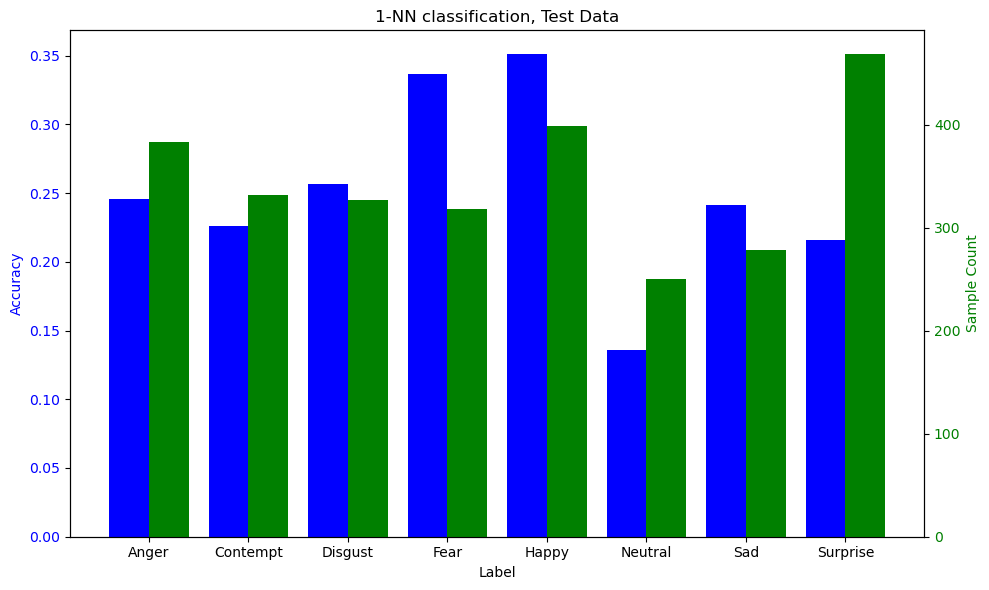

In [136]:
unique_labels = np.arange(8)  # Labels 0 to 7
label_names = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
accuracy_per_label = []
sample_counts = []
    

for x in unique_labels:
    indices_with_x = np.where(test_class_labels == x)  # Indices where label is x
    label_true = test_class_labels[indices_with_x]
    label_pred = nn_1_test[indices_with_x]  
    
    # Calculate accuracy for label x
    accuracy = accuracy_score(label_true, label_pred)
    accuracy_per_label.append(accuracy)
    
    # Count samples for label x
    sample_counts.append(len(label_true))

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy per label
ax1.bar(unique_labels - 0.2, accuracy_per_label, width=0.4, color='b', align='center', label='Accuracy')
ax1.set_xlabel('Label')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(unique_labels)  # Set x-ticks to label indices
ax1.set_xticklabels(label_names)  # Set x-tick labels to label names

# Plot sample count per label
ax2 = ax1.twinx()
ax2.bar(unique_labels + 0.2, sample_counts, width=0.4, color='g', align='center', label='Sample Count')
ax2.set_ylabel('Sample Count', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('1-NN classification, Test Data')
fig.tight_layout()
fig.savefig("1nn_classification.png")
plt.show()

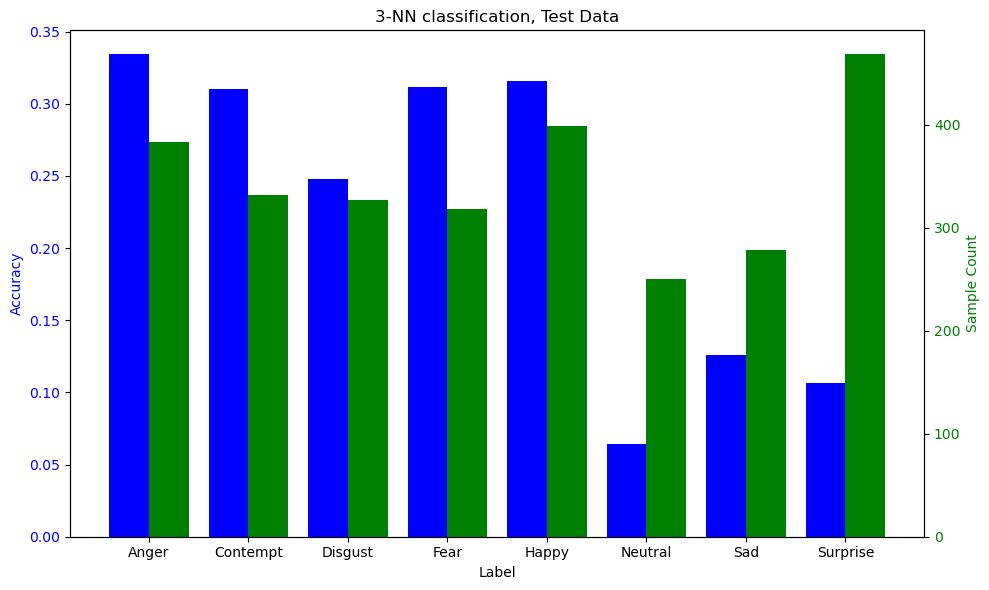

In [134]:
accuracy_per_label = []
sample_counts = []
    

for x in unique_labels:
    indices_with_x = np.where(test_class_labels == x) # Indices where label is x
    label_true = test_class_labels[indices_with_x]
    label_pred = nn_3_test[indices_with_x]  
    
    # Calculate accuracy for label x
    accuracy = accuracy_score(label_true, label_pred)
    accuracy_per_label.append(accuracy)
    
    # Count samples for label x
    sample_counts.append(len(label_true))

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy per label
ax1.bar(unique_labels - 0.2, accuracy_per_label, width=0.4, color='b', align='center', label='Accuracy')
ax1.set_xlabel('Label')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(unique_labels)  # Set x-ticks to label indices
ax1.set_xticklabels(label_names)  # Set x-tick labels to label names

# Plot sample count per label
ax2 = ax1.twinx()
ax2.bar(unique_labels + 0.2, sample_counts, width=0.4, color='g', align='center', label='Sample Count')
ax2.set_ylabel('Sample Count', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('3-NN classification, Test Data')
fig.tight_layout()
fig.savefig("3nn_classification.png")
plt.show()

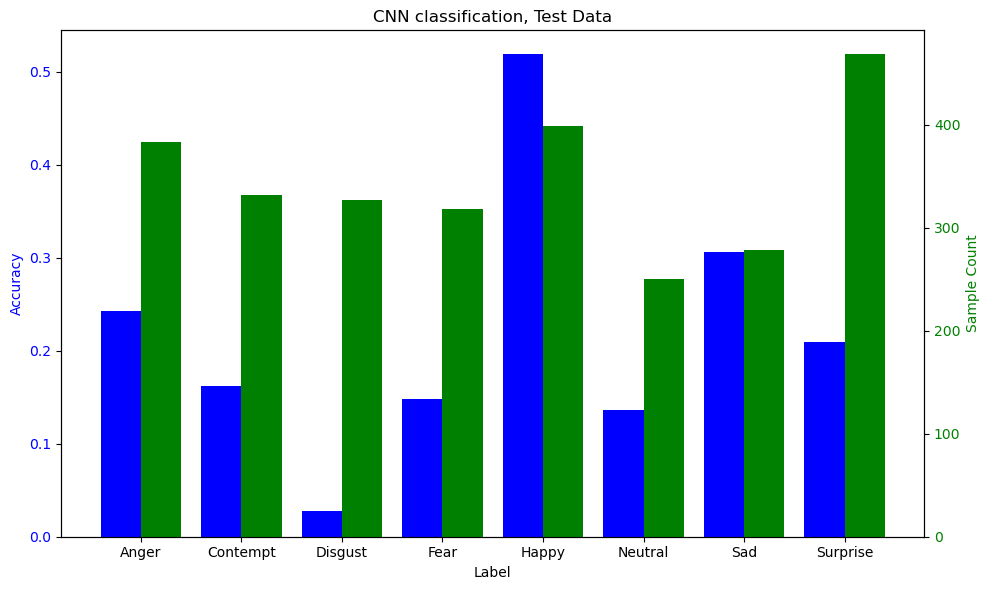

In [132]:
accuracy_per_label = []
sample_counts = []
    

for x in unique_labels:
    indices_with_x = np.where(test_class_labels == x)[0]  # Indices where label is x
    label_true = test_class_labels[indices_with_x]
    label_pred = ncc_test[indices_with_x]  
    
    # Calculate accuracy for label x
    accuracy = accuracy_score(label_true, label_pred)
    accuracy_per_label.append(accuracy)
    
    # Count samples for label x
    sample_counts.append(len(label_true))

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy per label
ax1.bar(unique_labels - 0.2, accuracy_per_label, width=0.4, color='b', align='center', label='Accuracy')
ax1.set_xlabel('Label')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(unique_labels)  # Set x-ticks to label indices
ax1.set_xticklabels(label_names)  # Set x-tick labels to label names

# Plot sample count per label
ax2 = ax1.twinx()
ax2.bar(unique_labels + 0.2, sample_counts, width=0.4, color='g', align='center', label='Sample Count')
ax2.set_ylabel('Sample Count', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('CNN classification, Test Data')
fig.tight_layout()
fig.savefig("ncc_classification.png")
plt.show()

# Confusion Matrices

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_knn_with_confusion_matrix(train_data, train_labels, test_data, test_labels, k, class_names):
    """
    Evaluate k-NN classifier and display confusion matrix.

    Args:
    - train_data: Training data samples.
    - train_labels: Training data labels.
    - test_data: Test data samples.
    - test_labels: Test data labels.
    - k: Number of neighbors for k-NN.
    - class_names: List of class names.

    Returns:
    - None
    """

    # Predict using k-NN
    test_pred = nearest_neighbor_classifier_cuda(train_data, train_labels, test_data, k)

    # Compute confusion matrix
    cm = confusion_matrix(test_labels, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Display confusion matrix
    print("k-NN Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)
    plt.title(f"k-NN (k={k}) Confusion Matrix")
    fig.savefig("3NN_confusion_matrix.png")
    plt.show()


In [70]:
def evaluate_centroid_with_confusion_matrix(train_data, train_labels, test_data, test_labels, class_names):
    """
    Evaluate Nearest Centroid classifier and display confusion matrix.

    Args:
    - train_data: Training data samples.
    - train_labels: Training data labels.
    - test_data: Test data samples.
    - test_labels: Test data labels.
    - class_names: List of class names.

    Returns:
    - None
    """

    # Predict using Nearest Class Centroid classifier
    test_pred = nearest_class_centroid_classifier_cuda(train_data, train_labels, test_data)

    # Compute confusion matrix
    cm = confusion_matrix(test_labels, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Display confusion matrix
    print("Nearest Centroid Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)
    plt.title("Nearest Centroid Confusion Matrix")
    fig.savefig("NC_Confusion_Matrix.png")
    plt.show()


k-NN Confusion Matrix:


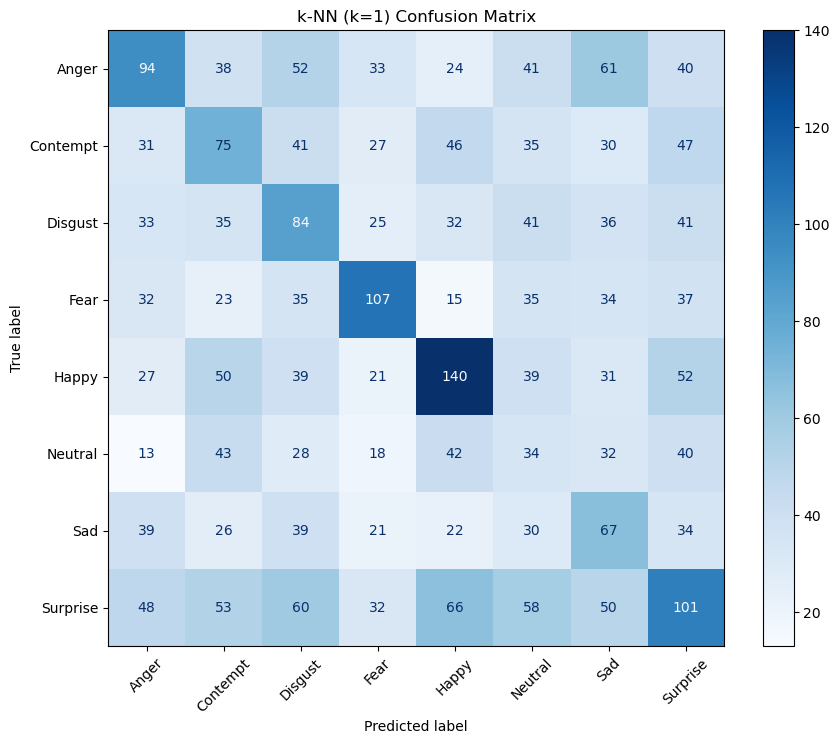

In [72]:
# 1-NN
evaluate_knn_with_confusion_matrix(train_image_data, train_class_labels, test_image_data, test_class_labels, k=1, class_names=class_names)

k-NN Confusion Matrix:


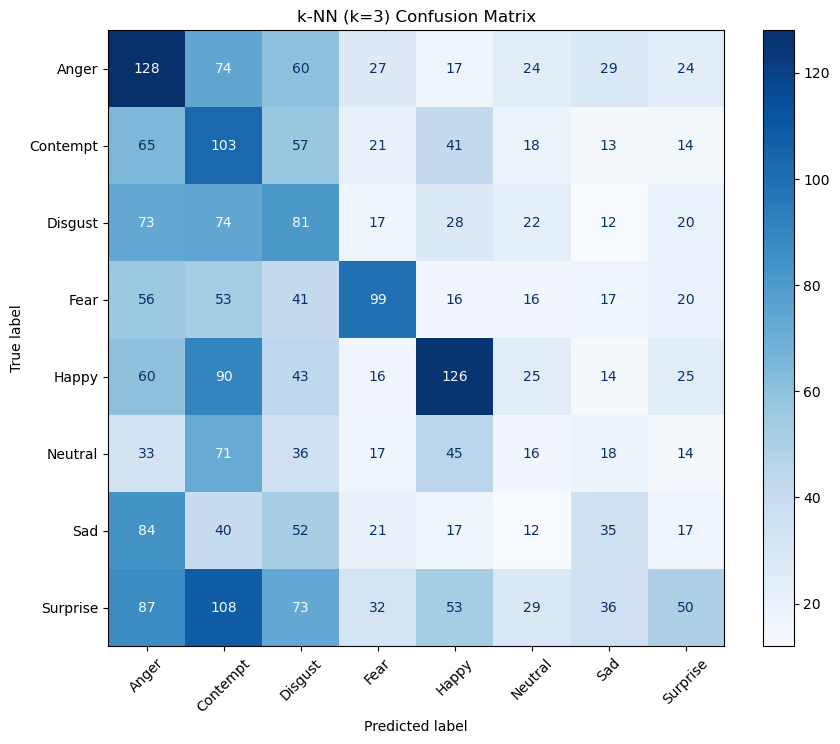

In [78]:
# 3-NN
evaluate_knn_with_confusion_matrix(train_image_data, train_class_labels, test_image_data, test_class_labels, k=3, class_names=class_names)

Nearest Centroid Confusion Matrix:


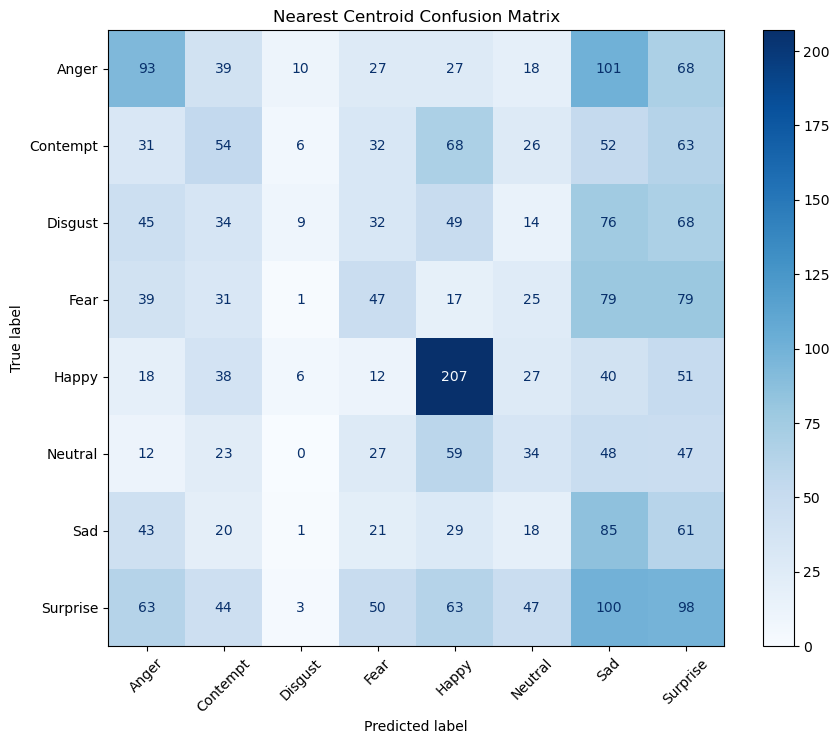

In [79]:
# Nearest Centroid 
evaluate_centroid_with_confusion_matrix(train_image_data, train_class_labels, test_image_data, test_class_labels, class_names=class_names)